# 2. Languages of Journals using OJS <a name=languages></a>

<a href='https://docs.google.com/document/d/103l90P0OuM0muOsmUYlnProG_Xo9yBR4IQ6INB21WaE/edit?usp=sharing'>This link</a> navigates to a google doc with examples of journals using OJS to publish open access articles in **56 different languages**. <br>

### Notebook objectives:
1. Obtain <a href='https://github.com/google/cld3'>gcld3 language classifications</a> for the abstracts of articles published in a sample of 22,559 ISSN-verified journals actively using OJS. 
2. Classify journals by their primary language of publishing.
3. Classify journals based on whether they publish in multiple languages.

Import packages:

In [1]:
from collections import defaultdict
from collections import Counter
from lxml import html
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import json
import time
import re
import os

### Google's Compact Language Detector v3 (gcld3)

Initialize <a href='https://github.com/google/cld3'>gcld3</a>:

In [2]:
import gcld3
classifier = gcld3.NNetLanguageIdentifier(min_num_bytes=0, max_num_bytes=10000)

Store a list of gcld3 language codes corresponding to the <a href='https://docs.google.com/document/d/103l90P0OuM0muOsmUYlnProG_Xo9yBR4IQ6INB21WaE/edit?usp=sharing'>56 languages known to be supported by OJS</a>:

In [3]:
known_langs = ['af', 'ar', 'bg', 'bg-Latn', 'bs', 'ca', 'cs', 'da', 'de', 'el', 'el-Latn', 'en', 'es', 'et', 'eu',
               'fa', 'fi', 'fr', 'gd', 'gl', 'hi', 'hi-Latn', 'hr', 'hu', 'hy', 'id', 'ig', 'is', 'it', 'ja',
               'ja-Latn', 'ka', 'kk', 'ko', 'lt', 'mk', 'ms', 'ne', 'nl', 'no', 'pl', 'pt', 'ro', 'ru', 'ru-Latn',
               'si', 'sk', 'sl', 'sr', 'sv', 'sw', 'ta', 'th', 'tr', 'uk', 'ur', 'uz', 'vi', 'zh', 'zh-Latn']

Create a function that:
<br>
1. Opens and streams a messy 28.5 GB file of scraped and printed OAI-PMH article metadata [title, description, subject, language, source...] for the most recent 100 journal articles published in **22,559 OJS contexts**;
<br><br>
2. Filters journals by ISSN and filters language predictions by inclusion in the list of known OJS languages (to avoid misclassification);
<br><br>
3. Passes the 'description' values (article abstracts) for the **most recent 100 articles published in each journal** to gcld3 to generate lists of predicted languages for each journal;
<br><br>
4. Returns a dict mapping journal issn to a list of gcld3-predicted language codes for article abstracts:

In [4]:
def classify_abstracts(path_to_dump, classifier, issn_filter, lang_filter):
    
    metadata_pattern = '<metadata>.+</metadata>'
    issn2langs = defaultdict(list) #defaultdict of lists
    dcount = defaultdict(int)
    #Full processing
    
    with open(path_to_dump, 'r') as f:
        article_count = 0
        
        for line in f:
            content = re.search(metadata_pattern, line, re.MULTILINE | re.DOTALL)
            if content:
                tree = html.fromstring(content.group())

                for article in tree.xpath('//metadata'):
                    article_count += 1
                    
                    for source in article.xpath('.//source'):
                        if source.text in issn_filter:
                            issn = source.text
                            
                            for description in article.xpath('.//description'):
                                if dcount[issn] < 100 and description is not None: #if <100 abstracts have been classified
                                    pred_ = classifier.FindLanguage(text=description.text) #run gcld3
                                    if pred_.is_reliable and pred_.language in lang_filter: 
                                        #if the language prediction is reliable and in a known OJS language
                                        issn2langs[issn].append(pred_.language)
                                        #append to a list of language predictions for the journal
                                        dcount[issn] += 1
                                    del pred_
                                        
                while tree.getprevious() is not None:
                    del tree.getparent()[0]
            del content
    
    print('Articles scanned: {}'.format(article_count))
    print('Journals classified: {}'.format(len(issn2langs)))
    return issn2langs

In [5]:
path_to_dump = os.path.join('data', 'datadump.txt')
path_to_beacon = os.path.join('data', 'beacon_active.csv')

In [6]:
with open(path_to_beacon, 'r') as f:
    df = pd.read_csv(f)
df = df[~df['issn_1'].duplicated()]
issn_filter = [i for i in df['issn_1'].tolist() if isinstance(i, str)]
print(len(issn_filter))

22809


In [7]:
%time issn2langs = classify_abstracts(path_to_dump, classifier, issn_filter, lang_filter=known_langs)

Articles scanned: 7960979
Journals classified: 22559
CPU times: user 2h 18min 54s, sys: 39.6 s, total: 2h 19min 34s
Wall time: 2h 19min 35s


Sanity check:

In [8]:
print(type(issn2langs))
for k, v in issn2langs.items():
    print(k) #issn for one journal
    print(v) #list of gcld3 language classifications for most recent 100 or fewer articles published in journal
    break

<class 'collections.defaultdict'>
2715-2502
['id', 'en', 'id', 'id', 'id', 'id', 'id', 'en', 'id', 'en', 'en', 'id', 'id', 'ms', 'id', 'en', 'id', 'en', 'id', 'id', 'en']


Next, create a function that:
<br>
1. Maps two digit language codes ('en') to languages ('English');
<br><br>
2. Determines the most common language in the list of language classifications for each journal;
<br><br>
3. Returns a dict mapping each issn to a single primary language code:

In [9]:
codes = {'af':'Afrikaans', 'ar':'Arabic', 'bg':'Bulgarian', 'bg-Latn':'Bulgarian', 'bs':'Bosnian', 'ca':'Catalan', 
         'cs':'Czech', 'da':'Danish', 'de':'German', 'el':'Greek', 'el-Latn':'Greek', 'en':'English', 
         'es':'Spanish', 'et':'Estonian', 'eu':'Basque', 'fa':'Persian', 'fi':'Finnish', 'fil':'Filipino',
         'fr':'French', 'ga':'Irish', 'gd':'Scottish Gaelic', 'gl':'Galician', 'hi':'Hindi','hi-Latn':'Hindi',
         'hr':'Croatian', 'hu':'Hungarian', 'hy':'Armenian', 'id':'Indonesian', 'ig':'Igbo', 'is':'Icelandic',
         'it':'Italian', 'iw':'Hebrew', 'ja':'Japanese', 'ja-Latn':'Japanese', 'ka':'Georgian', 'kk':'Kazakh',
         'ko':'Korean', 'ky':'Kyrgyz', 'la':'Latin', 'lt':'Lithuanian', 'lv':'Latvian', 'mk':'Macedonian',
         'ms':'Malay', 'my':'Burmese', 'ne':'Nepali', 'nl':'Dutch', 'no':'Norwegian', 'pl':'Polish',
         'pt':'Portuguese', 'ro':'Romanian', 'ru':'Russian', 'ru-Latn':'Russian', 'sd':'Sindhi', 'si':'Sinhala',
         'sk':'Slovak', 'sl':'Slovenian','sr':'Serbian', 'sv':'Swedish', 'sw':'Swahili', 'ta':'Tamil',
         'tg':'Tajik', 'th':'Thai', 'tr':'Turkish', 'uk':'Ukrainian', 'ur':'Urdu', 'uz':'Uzbek',
         'vi':'Vietnamese', 'zh':'Chinese', 'zh-Latn':'Chinese'}

In [10]:
def classify_journals_mono(issn2langs, known_langs):
    
    for k, v in issn2langs.items():
        if v:
            issn2langs[k] = [codes[lang] for lang in v]
    
    issn2primary = {}
    for k, v in issn2langs.items():
        if v:
            issn2primary[k] = Counter(v).most_common(1)[0][0]
        
    return issn2primary

In [11]:
issn2primary = classify_journals_mono(issn2langs, known_langs)

Get primary language counts for the entire sample of journals, which can then be visualized using pyplot and seaborn:

In [12]:
#Get value counts for the language codes
ls = pd.Series(list(issn2primary.values())).value_counts(sort=True, ascending=False)
#Convert the Series to a DataFrame
langDist = pd.DataFrame(ls, columns=['count'], index=ls.index)
langDist.reset_index(inplace=True)
langDist.rename(columns = {'index':'language'}, inplace=True)
#Total number of journals:
total = langDist['count'].sum()
#Print n
print('Total: {} journals'.format(total))

Total: 22559 journals


In [13]:
langDist.head(10)

,language,count
0,English,11304
1,Indonesian,5125
2,Spanish,2517
3,Portuguese,2184
4,Afrikaans,130
5,Russian,129
6,Ukrainian,128
7,German,122
8,French,110
9,Japanese,106


### Bar plot of the 10 primary languages in which OJS users publish their articles  (*n*=20,559) <br>
Each bar represents the proportion of journals for which the specified language is their primary publishing language.

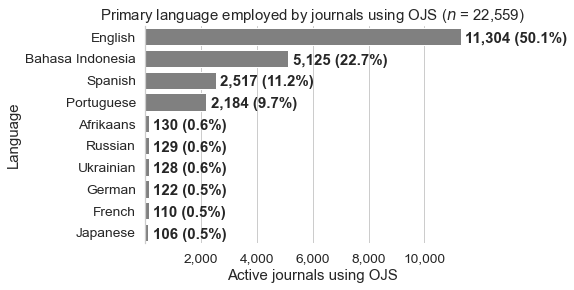

In [16]:
%matplotlib inline

sns.set(font_scale=1.25)
sns.set_style('whitegrid')
fig, ax = matplotlib.pyplot.subplots()

ld = sns.barplot(x=langDist['count'][:10],
                 y=['English', 'Bahasa Indonesia', 'Spanish', 'Portuguese', 'Afrikaans',
                    'Russian', 'Ukrainian', 'German', 'French', 'Japanese'],
                 data=langDist,
                 orient='h',
                 color='grey')

ax.set(xlim=(0, 12000),
       xlabel='Active journals using OJS',
       ylabel='Language',
       title='Primary language employed by journals using OJS ($\it{n}$ = 22,559)')

sns.despine(bottom=True)


matplotlib.pyplot.xticks([2000, 4000, 6000, 8000, 10000],
                         ['2,000', '4,000', '6,000', '8,000', '10,000'])

for p in ld.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.133
    percent = round(((p.get_width() / 22559) * 100), 1)
    string = str(int(p.get_width()))
    if len(string) == 5:
        value = string[:2] + ',' + string[2:]
    elif len(string) == 4:
        value = string[0] + ',' + string[1:]
    else:
        value = string
    value += ' ({})'.format(str(percent)+'%')
    ld.text(_x + 150, _y, value, ha='left', weight='bold')

fig.savefig('primary_languages.png', bbox_inches=('tight'))

### Bar plot of multilingualism among journals publishing with OJS  (*n*=22,559) <br>
Each bar represents the proportion of journals that published **5 or more articles in each of their publishing languages**.

In [17]:
def classify_journals_multi(issn2langs, decision_boundary):
    multilingual = defaultdict(list)
    for k, v in issn2langs.items():
        for lang in Counter(v).items():
            if lang[1] >= decision_boundary: 
                #If the the number of article abstracts tagged as a given language ('en') exceeds the boundary
                multilingual[k].append(lang[0]) #Append the language to a list for the journal
                
    multilingual_counts = defaultdict(int)
    array_lengths = []
    for v in multilingual.values():
        if v:
            multiplier = len(v)
            array_lengths.append(multiplier)
            if multiplier >= 3:
                multilingual_counts['Multi- (3+ languages)'] += 1
            elif multiplier == 2:
                multilingual_counts['Bi- (2 languages)'] += 1
            elif multiplier == 1:
                multilingual_counts['Mono- (1 language)'] += 1
            else:
                continue
            
    total = 0
    for v in multilingual_counts.values():
        total += v
    print('Total: {} journals'.format(total))
    print('Average number of languages per journal: {}'.format(np.array(array_lengths).mean()))
    
    return pd.Series(multilingual_counts).sort_values(ascending=False)

In [19]:
multi5 = classify_journals_multi(issn2langs, decision_boundary=5)

Total: 22382 journals
Average number of languages per journal: 1.6976588329907962


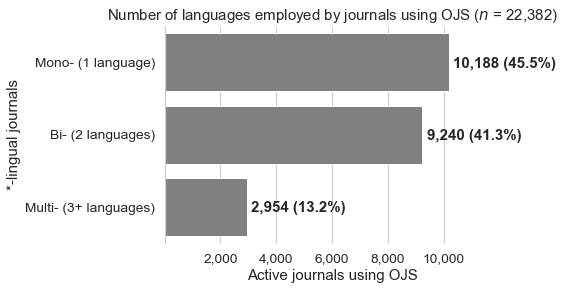

In [23]:
%matplotlib inline

sns.set(font_scale=1.25)
sns.set_style('whitegrid')

fig, ax = matplotlib.pyplot.subplots()

mult = sns.barplot(y=multi5.index,
                   x=multi5.values,
                   orient='h',
                   color='grey')

ax.set(xlim=(0, 12000),
       xlabel='Active journals using OJS',
       ylabel='*-lingual journals',
       title='Number of languages employed by journals using OJS ($\it{n}$ = 22,382)')

sns.despine(bottom=True)

matplotlib.pyplot.xticks([2000, 4000, 6000, 8000, 10000],
                         ['2,000', '4,000', '6,000', '8,000', '10,000'])

for p in mult.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 22382) * 100), 1)
    string = str(int(p.get_width()))
    if len(string) == 5:
        value = string[:2] + ',' + string[2:]
    elif len(string) == 4:
        value = string[0] + ',' + string[1:]
    else:
        value = string
    value += ' ({})'.format(str(percent)+'%')
    mult.text(_x + 150, _y, value, ha='left', weight='bold')

fig.savefig('multilingual5.png', bbox_inches=('tight'))

In [24]:
multi10 = classify_journals_multi(issn2langs, decision_boundary=10)

Total: 21666 journals
Average number of languages per journal: 1.5283393335179545


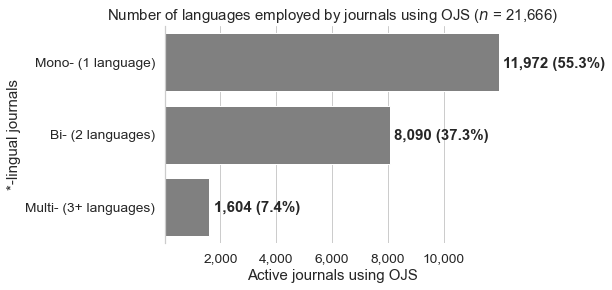

In [25]:
%matplotlib inline

sns.set(font_scale=1.25)
sns.set_style('whitegrid')

fig, ax = matplotlib.pyplot.subplots()

mult = sns.barplot(y=multi10.index,
                   x=multi10.values,
                   orient='h',
                   color='grey')

ax.set(xlim=(0, 12000),
       xlabel='Active journals using OJS',
       ylabel='*-lingual journals',
       title='Number of languages employed by journals using OJS ($\it{n}$ = 21,666)')

sns.despine(bottom=True)

matplotlib.pyplot.xticks([2000, 4000, 6000, 8000, 10000],
                         ['2,000', '4,000', '6,000', '8,000', '10,000'])

for p in mult.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 21666) * 100), 1)
    string = str(int(p.get_width()))
    if len(string) == 5:
        value = string[:2] + ',' + string[2:]
    elif len(string) == 4:
        value = string[0] + ',' + string[1:]
    else:
        value = string
    value += ' ({})'.format(str(percent)+'%')
    mult.text(_x + 150, _y, value, ha='left', weight='bold')

fig.savefig('multilingual10.png', bbox_inches=('tight'))